## CNN(PyTorch) - MNIST Upsampling Convolutional Autoencoder

Steps to perform Autoencoder
- Input data is passed through an encoder 
- Encoder will compress the input
- Compressed data is is passed through a decoder to reconstruct the input data


Note: In general, the encoder and decoder will be built with neural networks, then trained on example data.

Note: In this, decoder portion will be made of upsampling and convolutional layers (where as in transpose autoencoder, we will be using convtranspose)

### Importing libraries and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

### Loading data

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

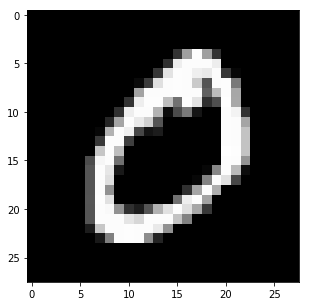

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[1])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.show()

### Creating Convolutional Autoencoder model

Steps to perform Autoencoder
- Input data is passed through an encoder
    - Input images are 28x28x1 in size. these images will be passed through encoder layers
- Encoder will compress the input
    - It will have convolutional layers followed by max pooling layer to reduce dimensions to 7x7x4
- Compressed data is is passed through a decoder to reconstruct the input data
    - This layer will bring back to original dimension 28x28x1
    - Will use a combination of nearest-neighbor upsampling and normal convolutional layers to increase the width and height of the input layers.
    - In this Distill article from Augustus Odena, et al, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.

Note: The images from this dataset are already normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.u_conv1 = nn.Conv2d(4, 16, 3, padding =1)
        self.u_conv2 = nn.Conv2d(16, 1, 3, padding =1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `upsample` in some PyTorch versions
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.u_conv1(x))
        # upsample again, output should have a sigmoid applied
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.sigmoid(self.u_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (u_conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (u_conv2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### Training

- With Autoencodes we dont need to check for labels because we will be comparing the original input to decoded output
- Because we are comparing pixel values in input and output images, we will use loss function for regession task. We will use MSELoss

In [5]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images, _ = data                        # we are just intrested in images
        # no need to flatten images
        optimizer.zero_grad()                   # clear the gradients
        outputs = model(images)                 # forward pass: compute predicted outputs 
        loss = criterion(outputs, images)       # calculate the loss
        loss.backward()                         # backward pass
        optimizer.step()                        # perform optimization step
        train_loss += loss.item()*images.size(0)# update running training loss
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
          '\tTraining Loss: {:.4f}'.format(train_loss))

Epoch: 1 	Training Loss: 0.4441
Epoch: 2 	Training Loss: 0.2458
Epoch: 3 	Training Loss: 0.2272
Epoch: 4 	Training Loss: 0.2185
Epoch: 5 	Training Loss: 0.2129
Epoch: 6 	Training Loss: 0.2084
Epoch: 7 	Training Loss: 0.2040
Epoch: 8 	Training Loss: 0.2004
Epoch: 9 	Training Loss: 0.1974
Epoch: 10 	Training Loss: 0.1951
Epoch: 11 	Training Loss: 0.1931
Epoch: 12 	Training Loss: 0.1915
Epoch: 13 	Training Loss: 0.1900
Epoch: 14 	Training Loss: 0.1887
Epoch: 15 	Training Loss: 0.1875
Epoch: 16 	Training Loss: 0.1865
Epoch: 17 	Training Loss: 0.1857
Epoch: 18 	Training Loss: 0.1851
Epoch: 19 	Training Loss: 0.1845
Epoch: 20 	Training Loss: 0.1839


### Comparing inputs before encoding and output after decoding

Below we can notice that ouput edges are not smooth like in inputs. This is due to checkerboard effect that will happen with transpose layers 

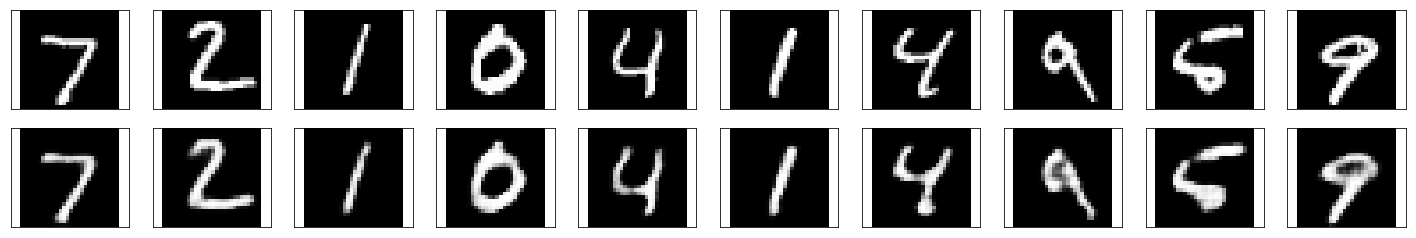

In [6]:
# Lets get batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)                     # get sample outputs
images = images.numpy()                    # prep images for display
output = output.view(batch_size, 1, 28, 28)# resizing output
output = output.detach().numpy()           # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)